ICI ca test de recup des infos sur nba.com

In [36]:
from selenium import webdriver #/!\ version :4.5.0
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

from bs4 import BeautifulSoup

import pandas as pd

import time

In [37]:
#create a constant for the url
NBA_PLAYERS_START_URL = 'https://www.nba.com/stats/alltime-leaders'

In [38]:
CHROME_DRIVER_PATH = 'C:/chromedriver.exe'
def startBrowser():
    s=Service(CHROME_DRIVER_PATH)
    return  webdriver.Chrome(service=s)

def isBrowserClosed(browser):
    isbrowserClosed = False
    try:
        webdriver.title
    except:
        isbrowserClosed = True
    return isbrowserClosed
        

In [39]:
def getDataFromURL(URL):
    browser = startBrowser()
    #open the url
    browser.get(URL)

    # accept cookies
    browser.find_element(By.CSS_SELECTOR, "button#onetrust-accept-btn-handler").click()
    time.sleep(10)
    #####################################################################################

    df = pd.DataFrame()

    while browser.find_element(By.CSS_SELECTOR, "button[title^='Next Page Button']").is_enabled():
        html = browser.page_source
        data, headers = getDataFromHTML(html)

        df = pd.concat([df, pd.DataFrame(data, columns=headers)], ignore_index=True)

        print("-", end = '')

        while True:
            try:
                browser.find_element(By.CSS_SELECTOR, "button[title^='Next Page Button']").click()
                break
            except:
                if(isBrowserClosed(browser)):
                    return df
                else:
                    print('not yet clickable')
                    continue

        html = browser.page_source
        data, headers = getDataFromHTML(html)

        df = pd.concat([df, pd.DataFrame(data, columns=headers)], ignore_index=True)

        print("-", end = '')

    #close the browser
    browser.quit()
    #return the dataframe
    return df



#Parsing the html and returning the data and headers.
def getDataFromHTML(html):
    #parse the html
    soup = BeautifulSoup(html, 'html.parser')
    #find the table with class Crom_table__p1iZz
    table = soup.find('table', attrs = {'class' : 'Crom_table__p1iZz'})
    #get the table headers
    headers = [header.text for header in table.findAll('th', attrs = {'hidden': None})]
    #get the table rows
    rows = table.find_all('tr')
    #get the table data
    data = [[td.text for td in rows[i].find_all('td')] for i in range(len(rows))]
    data = [row for row in data if row != []]#they is an empty at the start idk why but yes

    return data, headers


In [40]:
print("start of the scrapping")
df = getDataFromURL(NBA_PLAYERS_START_URL)
print("\nend of the scrapping\n\n")



print("saving the dataframe to a csv file...")
df.to_csv('nbaPlayersData.csv', index = False)
print("done")

start of the scrapping
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
end of the scrapping


saving the dataframe to a csv file...
done


      GP    MIN    PTS    FGM    FGA   FG%   3PM   3PA   3P%   FTM  ...   FT%  \
0  1 560  57446  38387  15837  28307  55.9     1    18   5.6  6712  ...  72.1   
1  1 374  52429  37254  13618  26999  50.4  2152  6244  34.5  7866  ...  73.4   
2  1 476  54852  36928  13528  26210  51.6    85   310  27.4  9787  ...  74.2   
3  1 346  48643  33643  11719  26200  44.7  1827  5546  32.9  8378  ...  83.7   
4  1 072  41010  32292  12192  24537  49.7   581  1778  32.7  7327  ...  83.5   

   OREB   DREB    REB    AST   STL   BLK   TOV  EFG%   TS%  
0  2975   9394  17440   5660  1160  3189  2527  55.9  59.2  
1  1616   8667  10283  10105  2145  1048  4818  54.4  58.7  
2  3562  11406  14968   5248  2085  1145  4524  51.8  57.7  
3  1499   5548   7047   6306  1944   640  4010  48.2  55.0  
4  1668   5004   6672   5633  2514   893  2924  50.9  56.9  

[5 rows x 21 columns]


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_14752\2928742246.py:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

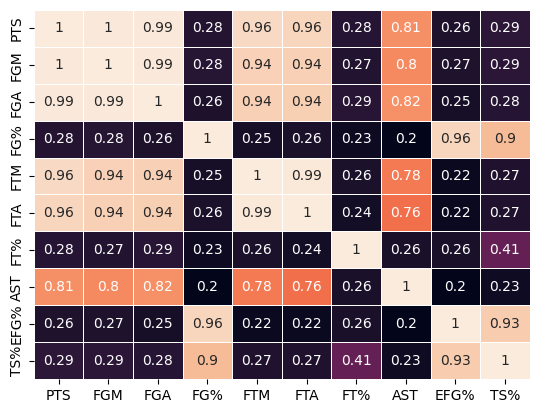

In [41]:
#load the csv file
df = pd.read_csv('nbaPlayersData.csv')

# replace all the - with Nan
df.replace('-', float('nan'), inplace = True)

# replace all the empty string with Nan
df.replace('', float('nan'), inplace = True)


#heatmap of correlation between the columns
import seaborn as sns
import matplotlib.pyplot as plt

#replace the Nan with 0
df.fillna(0, inplace = True)

#remove the column id and # and player
df.drop(['#', 'PLAYER'], axis = 1, inplace = True)

# print the first line
print(df.head())


corr = df.corr()
sns.heatmap(corr, annot=True, linewidths=0.5, cbar=False)